In [1]:
import pygsti
import matplotlib.pyplot as plt
from pygsti.extras import drift
import numpy as np
from data_list_creator import create_data
from helpers import *
from drift_file_io import drift_input, calculate_average_timestep, merge_lines
import NoiseSignal2 as ns
savepath = None

save = False
data_option = 3
###############file io (option 2) is for each line being one sample, merge (opt. 3) is to combine all lines into one sample
###########################################Manipulate variables here ###############################################
#################################################################################################################
#For reading in experimental data: enter here
if data_option == 2 or data_option == 3:
    base = "N:/Programs/Ions Share/Gate-Set Tomography/DriftAnalysis/" 
    name = '2018_08_27 Gi Data/2018_08_27_1627_08_DRIFT' #specify date_folder/txt_file_name
    file_loc = base + name + ".txt"
    time_per_sample = 1/60 #seconds, only necessary if you're doing the merge lines
    savepath = None
    if save and (data_option == 2 or data_option == 3):
        savepath = base  + name + "_Merged_Bitstring_Plot.png"
##################################################################################################################
##############################################################################################################
#Don't change anything below this line for regular program operation

if data_option == 2:
    raw_bit_array, ones_count_array, zeros_count_array, timestamp_array = drift_input(file_loc)
    time_per_sample = calculate_average_timestep(timestamp_array)
    print("Data is loaded...Beginning Drift Analysis")
elif data_option == 3:
    ones_count_array, zeros_count_array, timestamp_array = merge_lines(file_loc, time_per_sample)
    
#calculate results and print relevant information
print("Time per sample/timestep: {:.4f}".format(time_per_sample))
print("Samples per second: {:.2f}".format(1/time_per_sample))
nCounts = ones_count_array[0] + zeros_count_array[0] #the number of samples per timestep (zeros or ones)
print("Counts per timestep (sample): {}".format(nCounts))
nSamples = len(ones_count_array)
print("Total Samples/Timesteps: {}".format(nSamples))
print("Total time of Data Collection: {} s".format(timestamp_array[len(timestamp_array) - 1] - timestamp_array[0]))
drifted = drift.do_basic_drift_characterization(ones_count_array, counts=nCounts, timestep=time_per_sample,timestamps=timestamp_array, verbosity=0)
drifted.plot_power_spectrum(sequence=0, entity=0, outcome=1, savepath=savepath)

#analyze the frequency-power spectrum
frequencies = list(drifted.frequencies)
power_spectrum = list(drifted.pspepo_power_spectrum[0,0,1,:])
sorted_groups = create_sorted_tuples(frequencies, power_spectrum)
num_points = 5
for i in range(num_points):
    print("#{} Frequency: {:.4f} Hz".format(i+1, sorted_groups[i][0]))
#print("Spacing is {:.4f} Hz".format(frequencies[1]-frequencies[0]))
print("Highest frequency tested is {:.3f} Hz".format(frequencies[len(frequencies) - 1]))

if save:
    with open(base + name + "_Merged_Bitstring_Top_Freqs.txt","w") as out:
        out.write("Time per sample/timestep: {:.4f}\n".format(time_per_sample))
        out.write("Samples per second: {:.2f}\n\n".format(1/time_per_sample))
        for i in range(num_points):
            out.write("#{} Frequency: {:.3f} Hz\n".format(i+1, sorted_groups[i][0]))
            
    with open(base + name + "_Merged_Bitstring_All_Output.txt","w") as out:
        out.write("Frequency(Hz)\tPower(a.u.)\n")
        for i in range(len(frequencies)):
            out.write("{}\t{}\n".format(frequencies[i], power_spectrum[i]))

C:\Users\GA28573\Documents\pyGSTi-master\packages\pygsti\tools\matrixtools.py:23: UserWarning: Could not import Cython extension - falling back to slower pure-python routines
  _warnings.warn("Could not import Cython extension - falling back to slower pure-python routines")


Time per sample/timestep: 0.0167
Samples per second: 60.00
Counts per timestep (sample): 1
Total Samples/Timesteps: 186000
Total time of Data Collection: 3099.9666666666662 s


<Figure size 1500x300 with 1 Axes>

#1 Frequency: 1.2082 Hz
#2 Frequency: 0.0087 Hz
#3 Frequency: 1.2076 Hz
#4 Frequency: 0.0053 Hz
#5 Frequency: 0.0016 Hz
Highest frequency tested is 30.000 Hz


In [2]:
###################This cell is for truncating data and only seeing certain frequencies
if False:
    mindex = 10000
    maxdex = 15000 #len(frequencies)-1

    fig = plt.figure(figsize=(15,4))
    plt.plot(frequencies[mindex:maxdex], np.asarray(power_spectrum[mindex:maxdex])/nSamples,ls="solid",marker='.')
    plt.xlabel("Frequency, Hz")
    plt.ylabel("Power")
    plt.xlim((frequencies[mindex], frequencies[maxdex]))
    plt.title("TRUNCATED & NORMALIZED Merged-Line Power Spectrum with Indices {} to {}".format(mindex, maxdex))
    plt.show()

In [3]:
############# Display normalized spectrum (set the if statement to True)
if False:
    normalized_power_spectrum = np.asarray(power_spectrum)/nSamples
    plt.figure(figsize=(15,4))
    plt.plot(frequencies, normalized_power_spectrum)
    plt.title("Normalized Power Spectrum")
    plt.xlabel("Frequency, Hz")
    plt.ylabel("Normalized Power")
    plt.show()

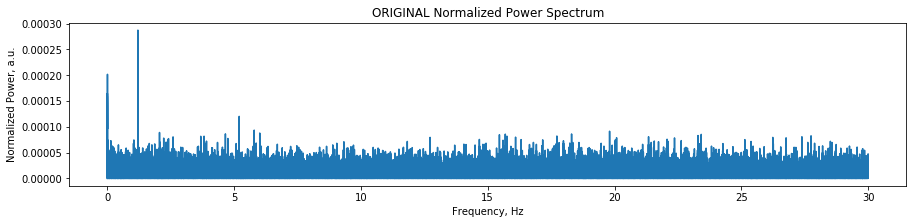

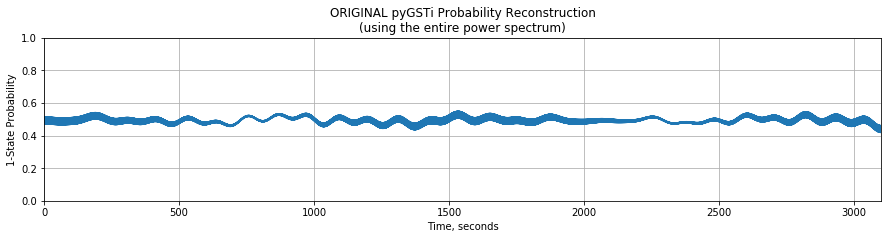

Using 1.2082 and 1.2076 Hz, with summed power 166.2162306077618


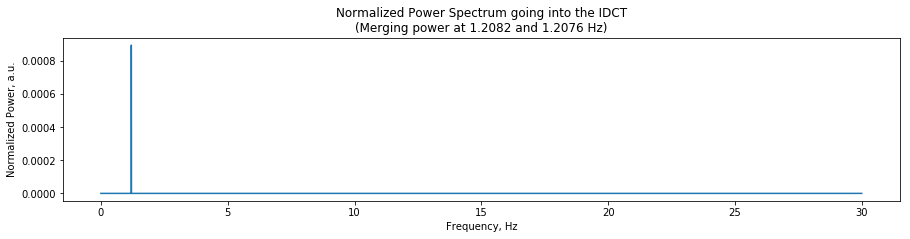

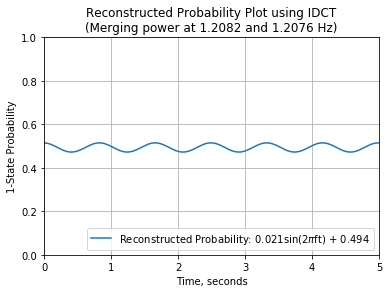

Frequency: 1.200 Hz
Amplitude: 0.021
Reconstructed frequency is 1.2000


In [4]:
###################### Reconstruct the probability function using various frequency inverse FT options
if True:
    central_freq = 1.2 #make sure this is on the peak from the power spectrum
    freq_band = 0.1
    print_info = True
    plot_original = True
    plot_results = True
    plot_range=(0,5)
    
    reconstructed_prob, reconst_f, reconst_amplitude = multi_frequency_reconstruction(drifted, central_freq, freq_band,\
                                    print_info=print_info, \
                                        plot_original=plot_original, plot_results=plot_results, plot_range=plot_range)
    print("Reconstructed frequency is {:.4f}".format(reconst_f))
    

C:\Users\GA28573\AppData\Local\Continuum\anaconda32\lib\site-packages\h5py\__init__.py:36: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



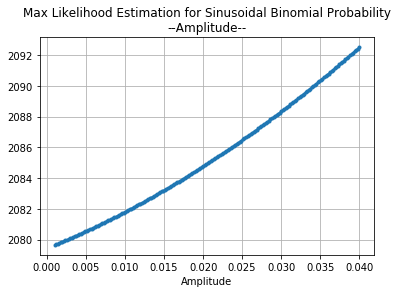

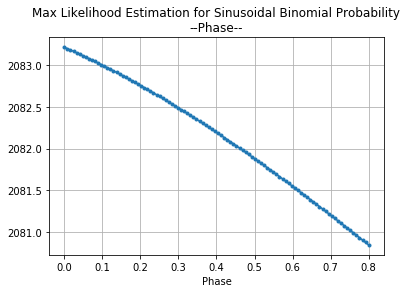

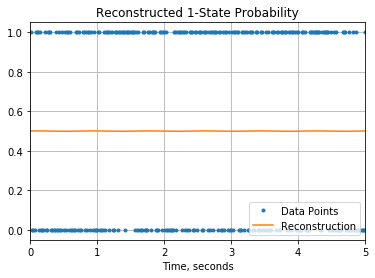

Frequency: 1.200 Hz
Amplitude: 0.001
Phase: 0.8 radians



In [5]:
from max_likelihood import loss, variable_loss, p1, p0, MLE, two_dimensional_optimization, three_dimensional_optimization

guess_values = (1.2, 0.015, 0) #frequency, amplitude, phase
freq_range = np.linspace(1.1, 1.3, 100)
amp_range = np.linspace(0.001, 0.04, 200)
phase_range = np.linspace(0.0, 0.8, 100)

form = 'sine' #'sine', 'square', or 'saw' (square allows you to specify a tpp)
input_f = 1.2
input_a = None
input_p = None
tpp = None

low_index = 0 #used for selecting how much data you want to send in
high_index = 3000
if True:
    input_times = timestamp_array[low_index:high_index]
    input_values = ones_count_array[low_index:high_index]    
    opt_times, opt_probs = MLE(input_times, input_values, guess_values, freq_range, amp_range, phase_range, form,\
       tpp, input_f, input_a, input_p, plot_range=(0,5))
    
    ### Do RMSE testing here
    reconst_one_counts = []
    for p in opt_probs:
        count_value = np.random.binomial(1, p)
        reconst_one_counts.append(count_value)
    RMSE = RMSE_comparison(reconst_one_counts, input_values)
    #print("RMSE for model above is {:.4f}".format(RMSE))

**Only using times 0.017 to 200.017 s (Complete time is from 0.017 to 3099.983 s)
Scanning amp & phase with F = 1.187 Hz
Scanning phase with A = 0.020
Scanning phase with A = 0.022
Scanning phase with A = 0.023
Scanning phase with A = 0.025
Scanning phase with A = 0.026
Scanning phase with A = 0.028
Scanning phase with A = 0.029
Scanning phase with A = 0.031
Scanning phase with A = 0.033
Scanning phase with A = 0.034
Scanning phase with A = 0.036
Scanning phase with A = 0.037
Scanning phase with A = 0.039
Scanning phase with A = 0.041
Scanning phase with A = 0.042
Scanning phase with A = 0.044
Scanning phase with A = 0.045
Scanning phase with A = 0.047
Scanning phase with A = 0.048
Scanning phase with A = 0.050
Scanning amp & phase with F = 1.187 Hz
Scanning phase with A = 0.020
Scanning phase with A = 0.022
Scanning phase with A = 0.023
Scanning phase with A = 0.025
Scanning phase with A = 0.026
Scanning phase with A = 0.028
Scanning phase with A = 0.029
Scanning phase with A = 0.031


Scanning phase with A = 0.042
Scanning phase with A = 0.044
Scanning phase with A = 0.045
Scanning phase with A = 0.047
Scanning phase with A = 0.048
Scanning phase with A = 0.050
Scanning amp & phase with F = 1.192 Hz
Scanning phase with A = 0.020
Scanning phase with A = 0.022
Scanning phase with A = 0.023
Scanning phase with A = 0.025
Scanning phase with A = 0.026
Scanning phase with A = 0.028
Scanning phase with A = 0.029
Scanning phase with A = 0.031
Scanning phase with A = 0.033
Scanning phase with A = 0.034
Scanning phase with A = 0.036
Scanning phase with A = 0.037
Scanning phase with A = 0.039
Scanning phase with A = 0.041
Scanning phase with A = 0.042
Scanning phase with A = 0.044
Scanning phase with A = 0.045
Scanning phase with A = 0.047
Scanning phase with A = 0.048
Scanning phase with A = 0.050
Scanning amp & phase with F = 1.193 Hz
Scanning phase with A = 0.020
Scanning phase with A = 0.022
Scanning phase with A = 0.023
Scanning phase with A = 0.025
Scanning phase with A 

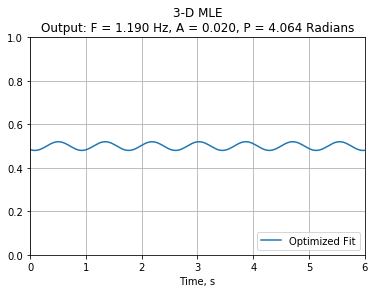

In [23]:
low_index = 0 #used for selecting how much data you want to send in
high_index = 12000
if True:
    input_times = timestamp_array[low_index:high_index]
    input_values = ones_count_array[low_index:high_index] 
    f_range=np.linspace(1.187, 1.195, 20)
    a_range=np.linspace(0.02, 0.05, 20)
    p_range=np.linspace(0.5, 1.5*np.pi, 14)
    form='sine'
    
    if input_times[-1] != timestamp_array[-1]:
        print("**Only using times {:.3f} to {:.3f} s (Complete time is from {:.3f} to {:.3f} s)".format(
            timestamp_array[low_index],timestamp_array[high_index], timestamp_array[0], timestamp_array[-1]))
    losses, opt_prob, opt_params = three_dimensional_optimization(
        input_times, input_values, f_range, a_range, p_range, form=form)
    
    
    
    plt.plot(input_times, opt_prob, label="Optimized Fit")
    plt.xlabel("Time, s")
    plt.title("3-D MLE\nOutput: F = {:.3f} Hz, A = {:.3f}, P = {:.3f} Radians".format(opt_params[0], opt_params[1], opt_params[2]))
    plt.xlim(0, 6)
    plt.ylim(0, 1)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()